# ENRC Demo

Brief demo showing how ENRC can be applied to the **Concatenated-MNIST** data set introduced in the ENRC paper, reference below:

`Lukas Miklautz, Dominik Mautz, Muzaffer Can Altinigneli, Christian Böhm, Claudia Plant:
Deep Embedded Non-Redundant Clustering. AAAI 2020: 5174-5181`

The jupyter notebook can be found [here](notebooks/ENRC/enrc_mnist.ipynb).

In [1]:
# Importing all necessary libraries

%load_ext autoreload
%autoreload 2

# internal packages
import os
from collections import Counter
# external packages
import torch
import torchvision
import numpy as np
import sklearn
from sklearn.metrics import normalized_mutual_info_score
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import cluspy
from cluspy.deep import encode_batchwise, get_dataloader
from cluspy.alternative import NrKmeans
from cluspy.metrics.multipe_labelings_scoring import MultipleLabelingsConfusionMatrix

# specify base paths

base_path = "material"
model_name = "autoencoder.pth"

print("Versions")
print("torch: ",torch.__version__)
print("torchvision: ",torchvision.__version__)
print("numpy: ", np.__version__)
print("scikit-learn:", sklearn.__version__)
print("cluspy:", cluspy.__version__)

Versions
torch:  1.11.0
torchvision:  0.12.0
numpy:  1.22.3
scikit-learn: 1.0.1
cluspy: 0.0.1


In [2]:
# Some helper functions, you can ignore those in the beginning
def denormalize_fn(tensor:torch.Tensor, mean:float, std:float, w:int, h:int)->torch.Tensor:
    """
    This applies an inverse z-transformation and reshaping to visualize the images properly.
    """
    pt_std = torch.as_tensor(std, dtype=torch.float32, device=tensor.device)
    pt_mean = torch.as_tensor(mean, dtype=torch.float32, device=tensor.device)
    return (tensor.mul(pt_std).add(pt_mean).view(-1, 1, h, w) * 255).int().detach()

def plot_images(images:torch.Tensor, pad:int=1):
    """Aligns multiple images on an N by 8 grid"""
    def imshow(img):
        plt.figure(figsize=(10, 20))
        npimg = img.numpy()
        npimg = np.array(npimg)
        plt.axis('off')
        plt.imshow(np.transpose(npimg, (1, 2, 0)),
                   vmin=0, vmax=1)
    
    imshow(torchvision.utils.make_grid(images, pad_value=255, normalize=False, padding=pad))
    plt.show();
    
def detect_device():
    """Automatically detects if you have a cuda enabled GPU"""
    if torch.cuda.is_available():
        device = torch.device('cuda:1')
    else:
        device = torch.device('cpu')
    return device

# Create Concatenated-MNIST data set

We create randomly paired MNIST digits to create a data set with classes from 00 to 99, where the left and right digit are independent of each other.

In [3]:
def load_mnist(train=True):
    # setup normalization function
    mnist_mean = 0.1307
    mnist_std = 0.3081
    normalize = torchvision.transforms.Normalize((mnist_mean,), (mnist_std,))
    # download the MNIST data set
    trainset = torchvision.datasets.MNIST(root='./data', train=train, download=True)
    data = trainset.data
    # preprocess the data
    # Scale to [0,1]
    data = data.float()/255
    # Apply z-transformation
#     data = normalize(data)
    # Flatten from a shape of (-1, 28,28) to (-1, 28*28)
    data = data.reshape(-1, data.shape[1] * data.shape[2])
    labels = trainset.targets
    return data, labels

data, labels = load_mnist()

random_state = np.random.randint(100000)
rng = np.random.default_rng(random_state)
subsample_size = 10000
rand_idx = rng.choice(data.shape[0], subsample_size, replace=False)

data_eval = data[rand_idx]
labels_eval = labels[rand_idx]

data_train = np.delete(data, rand_idx, axis=0)
labels_train = np.delete(labels, rand_idx,  axis=0)

data_test, labels_test = load_mnist(train=False)

print("Data Set Information")
print("Number of data points: ", data.shape[0])
print("Number of dimensions: ", data.shape[1])
print(f"Mean: {data.mean():.2f}, Standard deviation: {data.std():.2f}")
print(f"Min: {data.min():.2f}, Max: {data.max():.2f}")
print("Number of classes: ", len(set(labels.tolist())))
print("Class distribution:\n", sorted(Counter(labels.tolist()).items()))

Data Set Information
Number of data points:  60000
Number of dimensions:  784
Mean: 0.13, Standard deviation: 0.31
Min: 0.00, Max: 1.00
Number of classes:  10
Class distribution:
 [(0, 5923), (1, 6742), (2, 5958), (3, 6131), (4, 5842), (5, 5421), (6, 5918), (7, 6265), (8, 5851), (9, 5949)]


In [4]:
def create_random_pairings(data, labels, random_state=None, data_cat_dim=3):
    """Creates a random pairings between two images"""
    if random_state is None:
        random_state = np.random.randint(100000)
    rng = np.random.default_rng(random_state)
    left_idx = rng.choice(data.shape[0], data.shape[0], replace=False)
    right_idx = rng.choice(data.shape[0], data.shape[0], replace=False)

    left_data = data[left_idx].clone()
    right_data = data[right_idx].clone()
    left_labels = labels[left_idx].clone()
    right_labels = labels[right_idx].clone()
    concat_data = torch.cat([left_data, right_data], data_cat_dim)
    concat_labels = torch.stack([left_labels, right_labels], dim=1)
    return concat_data, concat_labels

In [5]:
# Specify random state if you want to use the same pairing across runs
random_state = None
concat_data, concat_labels = create_random_pairings(data.reshape(-1, 1, 28, 28), labels, random_state)
# Flatten data for feed forward network
concat_data = concat_data.reshape(-1, 28*56)
# z-transform
mean = concat_data.mean()
std = concat_data.std()

denormalize = lambda x: denormalize_fn(x, mean=mean, std=std, w=56, h=28)

concat_data -= mean
concat_data /= std
random_state = np.random.randint(100000)
rng = np.random.default_rng(random_state)
subsample_size = 10000
rand_idx = rng.choice(concat_data.shape[0], subsample_size, replace=False)

data_eval = concat_data[rand_idx]
labels_eval = concat_labels[rand_idx]

data_train = np.delete(concat_data, rand_idx, axis=0)
labels_train = np.delete(concat_labels, rand_idx,  axis=0)


print("Data Set Information")
print("Number of data points: ", concat_data.shape[0])
print("Number of dimensions: ", concat_data.shape[1])
print(f"Mean: {concat_data.mean():.2f}, Standard deviation: {concat_data.std():.2f}")
print(f"Min: {concat_data.min():.2f}, Max: {concat_data.max():.2f}")
for labeling in concat_labels.t():
    print("Number of classes: ", len(set(labeling.tolist())))
    print("Class distribution:\n", sorted(Counter(labeling.tolist()).items()))

Data Set Information
Number of data points:  60000
Number of dimensions:  1568
Mean: 0.00, Standard deviation: 1.00
Min: -0.42, Max: 2.82
Number of classes:  10
Class distribution:
 [(0, 5923), (1, 6742), (2, 5958), (3, 6131), (4, 5842), (5, 5421), (6, 5918), (7, 6265), (8, 5851), (9, 5949)]
Number of classes:  10
Class distribution:
 [(0, 5923), (1, 6742), (2, 5958), (3, 6131), (4, 5842), (5, 5421), (6, 5918), (7, 6265), (8, 5851), (9, 5949)]


Plot some images to see if everything worked:


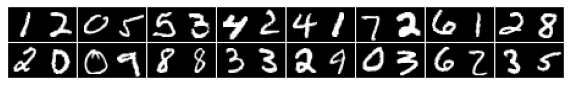

In [6]:
print("Plot some images to see if everything worked:")

plot_images(denormalize(concat_data[0:16]))


# Pretrain Autoencoder

In [7]:
from cluspy.deep import FlexibleAutoencoder

model = FlexibleAutoencoder(layers=[concat_data.shape[1], 1024, 512, 256, 20])
model

FlexibleAutoencoder(
  (encoder): FullyConnectedBlock(
    (block): Sequential(
      (0): Linear(in_features=1568, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=1024, out_features=512, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=512, out_features=256, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=256, out_features=20, bias=True)
    )
  )
  (decoder): FullyConnectedBlock(
    (block): Sequential(
      (0): Linear(in_features=20, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=256, out_features=512, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=512, out_features=1024, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=1024, out_features=1568, bias=True)
    )
  )
)

In [8]:
# Set all parameters needed for training

# The size of the mini-batch that is passed in each trainings iteration
batch_size = 128
# The learning rate specifies the step size of the gradient descent algorithm
learning_rate = 1e-3
# Set device on which the model should be trained on (For most of you this will be the CPU)
device = detect_device()
print("Use device: ", device)

# load model to device
model.to(device)

# create a Dataloader to train the autoencoder in mini-batch fashion
trainloader = get_dataloader(data_train, batch_size=batch_size, shuffle=True, drop_last=True, additional_inputs=[labels_train])

# create a Dataloader to evaluate the autoencoder in mini-batch fashion
evalloader = get_dataloader(data_eval, batch_size=batch_size, shuffle=False, drop_last=False, additional_inputs=[labels_eval])



# create a Dataloader to evaluate the autoencoder in mini-batch fashion  on the full data
fullloader = get_dataloader(concat_data, batch_size=batch_size, shuffle=False, drop_last=False, additional_inputs=[concat_labels])


# define optimizer (use a high weight decay as regularization and such that the embedded data has a small magnitude)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=1e-2)

# define loss function
loss_fn = torch.nn.MSELoss()

# path to were we want to save/load the model to/from
pretrained_model_name = "pretrained_" + model_name
pretrained_model_path = os.path.join(base_path, pretrained_model_name)


Use device:  cuda:1


In [9]:
# Train and save model
model_path = "test_cat.pth"
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau
scheduler_params = {"factor":0.9, "patience":5, "verbose":True}
model.fit(n_epochs=200, lr=learning_rate, dataloader=trainloader, evalloader=evalloader, device=device, model_path=model_path,
         scheduler=scheduler, scheduler_params=scheduler_params, print_step=5)

Epoch 1/199 - Batch Reconstruction loss: 0.285183
Epoch 1 EVAL loss total: 0.283925
Epoch 6/199 - Batch Reconstruction loss: 0.202321
Epoch 6 EVAL loss total: 0.199433
Epoch 11/199 - Batch Reconstruction loss: 0.166647
Epoch 11 EVAL loss total: 0.178877
Epoch 16/199 - Batch Reconstruction loss: 0.166482
Epoch 16 EVAL loss total: 0.170863
Epoch 21/199 - Batch Reconstruction loss: 0.150828
Epoch 21 EVAL loss total: 0.167065
Epoch 26/199 - Batch Reconstruction loss: 0.144441
Epoch 26 EVAL loss total: 0.162418
Epoch 31/199 - Batch Reconstruction loss: 0.140614
Epoch 31 EVAL loss total: 0.161652
Epoch 36/199 - Batch Reconstruction loss: 0.143041
Epoch 36 EVAL loss total: 0.158270
Epoch 41/199 - Batch Reconstruction loss: 0.127747
Epoch 41 EVAL loss total: 0.158987
Epoch 46/199 - Batch Reconstruction loss: 0.140007
Epoch 46 EVAL loss total: 0.156236
Epoch 51/199 - Batch Reconstruction loss: 0.124965
Epoch 51 EVAL loss total: 0.155962
Stop training at epoch 47
Best Loss: 0.155943, Last Loss: 

FlexibleAutoencoder(
  (encoder): FullyConnectedBlock(
    (block): Sequential(
      (0): Linear(in_features=1568, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=1024, out_features=512, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=512, out_features=256, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=256, out_features=20, bias=True)
    )
  )
  (decoder): FullyConnectedBlock(
    (block): Sequential(
      (0): Linear(in_features=20, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=256, out_features=512, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=512, out_features=1024, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=1024, out_features=1568, bias=True)
    )
  )
)

In [10]:
# load best model (can be executed in case model was previously saved)
sd = torch.load(model_path)
model.load_state_dict(sd)
model.eval()

FlexibleAutoencoder(
  (encoder): FullyConnectedBlock(
    (block): Sequential(
      (0): Linear(in_features=1568, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=1024, out_features=512, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=512, out_features=256, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=256, out_features=20, bias=True)
    )
  )
  (decoder): FullyConnectedBlock(
    (block): Sequential(
      (0): Linear(in_features=20, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=256, out_features=512, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=512, out_features=1024, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=1024, out_features=1568, bias=True)
    )
  )
)

Original Images


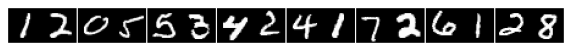

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Reconstructed Images


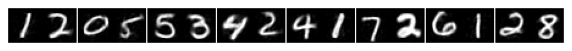

In [11]:
# Plot how well we are at reconstructing the data:
to_plot = 8
print("Original Images")
plot_images(denormalize(concat_data[0:to_plot]))
print("Reconstructed Images")
reconstruction = model(concat_data[0:to_plot].to(device)).detach().cpu()
plot_images(denormalize(reconstruction))

# Apply NrKmeans to the AE Embedding as a baseline

In [12]:
from cluspy.alternative import NrKmeans
n_clusters = [10,10]
embedded_data = encode_batchwise(fullloader, model, device)
nrkmeans = NrKmeans(n_clusters=n_clusters)
preds = nrkmeans.fit_predict(embedded_data)


## NMI for all cluster combinations

We see that two clusterings could be found and the two subspaces are mutually non-redundant (the opposite clusterings are close to zero).

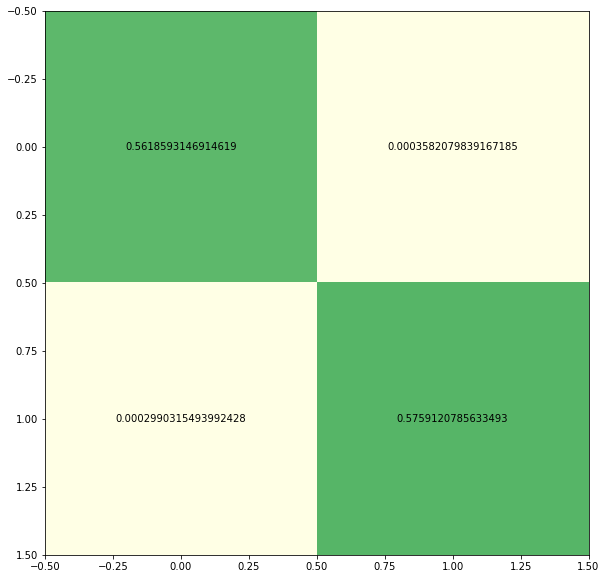

In [13]:
cm = MultipleLabelingsConfusionMatrix(labels_true=concat_labels, labels_pred=preds)
cm.plot()

In [14]:
# Indices of the dimension of each clustering
for i, P_i in enumerate(nrkmeans.P):
    print(f"Clustering {i} dims: {P_i}")


Clustering 0 dims: [ 3  2  6 10 19  7 12 11 17 16]
Clustering 1 dims: [ 0  4  9  8 18 15 13  5 14  1]


# Apply ENRC

In [15]:
from cluspy.deep.enrc import ENRC
# load best model
sd = torch.load(model_path)
model.load_state_dict(sd)
model.eval()

scheduler = torch.optim.lr_scheduler.StepLR
scheduler_params = {"step_size":40, "gamma":0.9}

enrc = ENRC(n_clusters=[10,10], 
            batch_size=128, 
            # Reduce learning_rate by factor of 10 as usually done in Deep Clustering for stable training
            clustering_learning_rate=learning_rate*0.1,
            clustering_epochs=400,
            autoencoder=model,
            # Use nrkmeans to initialize ENRC
            init="nrkmeans",
            # Use a random subsample of the data to speed up the initialization procedure
            init_subsample_size=10000,
            device=device,
            scheduler=scheduler,
            scheduler_params=scheduler_params,
            # Prints training information
            verbose=True,
            )

In [16]:
enrc.fit(concat_data.numpy())

Run ENRC init:  nrkmeans
Round 0: Found solution with: 377665.5636499811 (current best: 377665.5636499811)
Round 1: Found solution with: 381134.3259943916 (current best: 377665.5636499811)
Round 2: Found solution with: 375718.5733686376 (current best: 375718.5733686376)
Round 3: Found solution with: 374316.696198132 (current best: 374316.696198132)
Round 4: Found solution with: 375319.7236772842 (current best: 374316.696198132)
Round 5: Found solution with: 374422.7587405634 (current best: 374316.696198132)
Round 6: Found solution with: 374757.86207669904 (current best: 374316.696198132)
Round 7: Found solution with: 374361.437904591 (current best: 374316.696198132)
Round 8: Found solution with: 376783.771318484 (current best: 374316.696198132)
Round 9: Found solution with: 374257.9725125192 (current best: 374257.9725125192)
Start ENRC training
Epoch 1/399: summed_loss: 0.3399, subspace_losses: 0.0480, rec_loss: 0.2919, rotation_loss: 0.0060
Epoch 11/399: summed_loss: 0.1849, subspace_

ENRC(P=[array([ 9, 11, 18,  3, 10,  1, 14, 16, 12,  5]),
        array([ 2,  6, 13,  7,  0, 19, 15,  8,  4, 17])],
     V=array([[-1.17575228e-01,  3.14788699e-01, -4.08440202e-01,
         3.72170955e-01, -4.85883325e-01, -4.73220319e-01,
        -9.35577825e-02,  1.92871183e-01,  4.42588329e-02,
         1.94769815e-01, -1.55951068e-01, -1.48653045e-01,
        -2.73746431e-01,  5.13128519e-01, -4.79664564e-01,
        -1.75671652e-02,  3.22577000e-0...
      (4): Linear(in_features=512, out_features=1024, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=1024, out_features=1568, bias=True)
    )
  )
),
     clustering_epochs=400, device=device(type='cuda', index=1),
     init_subsample_size=10000, n_clusters=[10, 10],
     scheduler=<class 'torch.optim.lr_scheduler.StepLR'>,
     scheduler_params={'gamma': 0.9, 'step_size': 40}, verbose=True)

In [17]:
# Indices of the dimension of each clustering
for i, P_i in enumerate(enrc.P):
    print(f"Clustering {i} dims: {P_i}")

Clustering 0 dims: [ 9 11 18  3 10  1 14 16 12  5]
Clustering 1 dims: [ 2  6 13  7  0 19 15  8  4 17]


<AxesSubplot:>

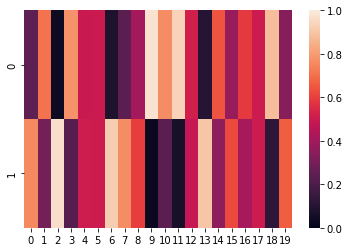

In [18]:
# Soft Beta Weights
sns.heatmap(enrc.betas, vmin=0, vmax=1.0)

## NMI for all cluster combinations

We see that we could improve upon the results of NrKmeans and the two subspaces are non-redundant.

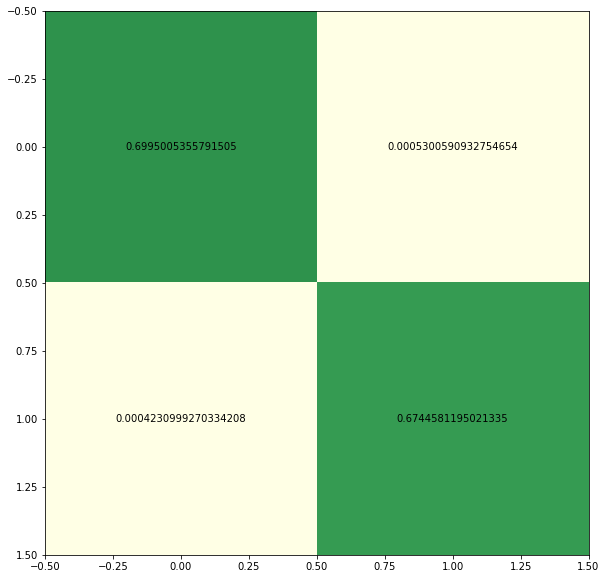

In [19]:
cm = MultipleLabelingsConfusionMatrix(labels_true=concat_labels, labels_pred=enrc.labels_)
cm.plot()

## Plot reconstructed centroids from each clustering

We see that for the centers of clustering 0 only the left side digits change, while for the clustering 1 only the right side digits change.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Centers of Clustering  0


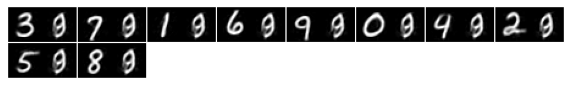

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Centers of Clustering  1


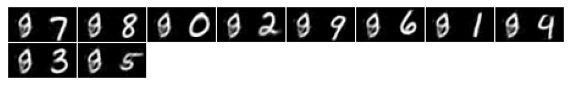

In [23]:
for subspace_i in range(len(enrc.P)):
    rec_centers = enrc.reconstruct_subspace_centroids(subspace_i)
    print("Centers of Clustering ", subspace_i)
    plot_images(denormalize(torch.from_numpy(rec_centers)))
    plt.show();